# [FinRL: 强化学习在量化金融中的应用](https://github.com/QYQSDTC/FinRL)
*注：本文不构成任何投资建议，入市有风险，投资需谨慎。*
## 小组成员
钱以骞 物理学院 D202180035

## 目标
- 了解强化学习在量化金融中的应用
- 通过强化学习的方法，实现一个简单的量化交易策略
- 比较不同的强化学习算法在量化金融中的表现
  - 钱以骞：DDPG

## 用到的Package
- [FinRL](https://github.com/AI4Finance-Foundation/FinRL): 一个强化学习在量化金融中的应用的开源库
- [Tushare](https://tushare.pro/): 一个免费的金融数据接口
- [Quantopian Pyfolio](https://github.com/quantopian/pyfolio): 一个自动化回测工具包

### Import modules

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from IPython import display
display.set_matplotlib_formats("svg")

from meta import config
from meta.data_processors.tushare import Tushare, ReturnPlotter
from meta.env_stock_trading.env_stocktrading_China_A_shares import StockTradingEnv
from agents.stablebaselines3_models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
pd.options.display.max_columns = None
import datetime
    
print("ALL Modules have been imported!")

ALL Modules have been imported!


## Create folders

In [2]:
import os
if not os.path.exists("./datasets" ):
    os.makedirs("./datasets" )
if not os.path.exists("./trained_models"):
    os.makedirs("./trained_models" )
if not os.path.exists("./tensorboard_log"):
    os.makedirs("./tensorboard_log" )
if not os.path.exists("./results" ):
    os.makedirs("./results" )

## Data preparation: download, cleansing and feature engineering
我们用Tushare获取了A股市场近10年的数据 (2012/01/01 -- 2022/09/28)，包括开盘价、收盘价、最高价、最低价、成交量、成交额、涨跌幅等信息。我们用这些数据来训练我们的强化学习模型。
### 个股的选择
因为本项目的主要目的是研究强化学习在量化金融中的应用，所以个股的选择我们就简单的从上证50中选取了5只权重股，包括：贵州茅台，万华化学，中国平安，中国中免，恒瑞医药。

如果想要更好的收益，可以用量化因子选股或者其它的一些量化方法，但是这不在本项目的讨论范围内。

In [3]:
ticket_list=['600519.SH', '600309.SH', '601318.SH', '601888.SH', '600276.SH']

train_start_date='2012-01-01'
train_stop_date='2020-01-01'
trade_start_date='2020-01-01'
trade_stop_date='2022-09-28'

# token='27080ec403c0218f96f388bca1b1d85329d563c91a43672239619ef5'
token='829a1fbce8eb0e34f05ab19906d0e08227c6f64261a81272aa078ccd'

In [4]:
# download and clean
ts_processor = Tushare(data_source="tushare", 
                                   start_date=train_start_date,
                                   end_date=trade_stop_date,
                                   time_interval="1d",
                                   token=token)
ts_processor.download_data(ticker_list=ticket_list)
ts_processor.dataframe.to_csv('./datasets/A_stock.csv')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.37it/s]

Shape of DataFrame:  (12849, 8)


In [5]:
ts_processor.clean_data()
ts_processor.dataframe

Shape of DataFrame:  (13055, 8)


,tic,date,open,high,low,close,volume,day
0,600276.SH,2012-01-04,29.50,29.75,28.40,28.45,11847.13,2.0
1,600309.SH,2012-01-04,12.97,13.10,12.45,12.50,96092.38,2.0
2,600519.SH,2012-01-04,191.50,192.77,185.00,185.27,33878.28,2.0
3,601318.SH,2012-01-04,34.89,35.00,33.81,33.90,145722.00,2.0
4,601888.SH,2012-01-04,26.59,26.77,25.58,25.59,12186.29,2.0
...,...,...,...,...,...,...,...,...
13050,600276.SH,2022-09-28,33.63,33.99,33.21,33.47,297009.83,2.0
13051,600309.SH,2022-09-28,88.88,89.87,86.80,87.08,106504.83,2.0
13052,600519.SH,2022-09-28,1880.50,1899.40,1874.01,1883.00,21445.97,2.0
13053,601318.SH,2022-09-28,42.20,42.50,41.85,41.89,422043.72,2.0


In [6]:
# add_technical_indicator
ts_processor.add_technical_indicator(config.INDICATORS)
ts_processor.clean_data()
ts_processor.dataframe

tech_indicator_list:  ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']
indicator:  macd
indicator:  boll_ub
indicator:  boll_lb
indicator:  rsi_30
indicator:  cci_30
indicator:  dx_30
indicator:  close_30_sma
indicator:  close_60_sma
Succesfully add technical indicators
Shape of DataFrame:  (13050, 17)


,tic,date,index,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,600276.SH,2012-01-05,5,28.04,28.50,26.60,27.00,38922.96,3.0,-0.032532,29.775610,25.674390,0.000000,-66.666667,100.000000,27.725000,27.725000
1,600309.SH,2012-01-05,6,12.49,12.65,12.00,12.10,98669.94,3.0,-0.008974,12.865685,11.734315,0.000000,-66.666667,100.000000,12.300000,12.300000
2,600519.SH,2012-01-05,7,184.00,185.20,182.36,183.15,30122.64,3.0,-0.047564,187.208133,181.211867,0.000000,-66.666667,100.000000,184.210000,184.210000
3,601318.SH,2012-01-05,8,33.55,34.60,33.52,33.93,181671.25,3.0,0.000673,33.957426,33.872574,100.000000,-66.666667,100.000000,33.915000,33.915000
4,601888.SH,2012-01-05,9,25.70,26.38,24.06,24.17,33085.74,3.0,-0.031859,26.888183,22.871817,0.000000,-66.666667,100.000000,24.880000,24.880000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13045,600276.SH,2022-09-28,13050,33.63,33.99,33.21,33.47,297009.83,2.0,-0.594860,36.002749,32.078251,46.037387,-73.380329,26.472473,34.372667,35.804333
13046,600309.SH,2022-09-28,13051,88.88,89.87,86.80,87.08,106504.83,2.0,-0.157221,94.403229,85.080771,48.103587,-46.881289,14.550696,89.145333,88.097667
13047,600519.SH,2022-09-28,13052,1880.50,1899.40,1874.01,1883.00,21445.97,2.0,-5.755540,1915.978241,1805.178759,50.211892,53.555970,8.828047,1869.003000,1900.694333
13048,601318.SH,2022-09-28,13053,42.20,42.50,41.85,41.89,422043.72,2.0,-0.105208,45.368779,41.870221,44.251555,-66.254626,2.799720,43.037333,42.911000


### Split traning dataset

In [7]:
ts_processor.dataframe.to_csv('./datasets/A_stock_processed.csv')

In [8]:
train =ts_processor.data_split(ts_processor.dataframe, train_start_date, train_stop_date)       
len(train.tic.unique())

5

In [9]:
train.tic.unique()

array(['600276.SH', '600309.SH', '600519.SH', '601318.SH', '601888.SH'],
      dtype=object)

In [10]:
train.head()

,tic,date,index,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,600276.SH,2012-01-05,5,28.04,28.50,26.60,27.00,38922.96,3.0,-0.032532,29.775610,25.674390,0.0,-66.666667,100.0,27.725,27.725
0,600309.SH,2012-01-05,6,12.49,12.65,12.00,12.10,98669.94,3.0,-0.008974,12.865685,11.734315,0.0,-66.666667,100.0,12.300,12.300
0,600519.SH,2012-01-05,7,184.00,185.20,182.36,183.15,30122.64,3.0,-0.047564,187.208133,181.211867,0.0,-66.666667,100.0,184.210,184.210
0,601318.SH,2012-01-05,8,33.55,34.60,33.52,33.93,181671.25,3.0,0.000673,33.957426,33.872574,100.0,-66.666667,100.0,33.915,33.915
0,601888.SH,2012-01-05,9,25.70,26.38,24.06,24.17,33085.74,3.0,-0.031859,26.888183,22.871817,0.0,-66.666667,100.0,24.880,24.880


In [11]:
train.shape

(9720, 17)

In [12]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension*(len(config.INDICATORS)+2)+1 # (indicators + close_price + shares) * num_stock + cash
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 5, State Space: 51


# 构建金融仿真环境
FinRL中为我们构建了一个和OpenAI Gym-style类似的金融仿真环境，通过agent和该环境互动，包括监测股价的变动，动作的采取和奖励的计算，agent最终可以学习到一个交易策略以期最大化收益。

In [13]:
env_kwargs = {
    "stock_dim": stock_dimension,
    "hmax": 1000, 
    "initial_amount": 1000000, 
    "buy_cost_pct":2e-4,
    "sell_cost_pct":2e-4,
    "reward_scaling": 1e-4,
    "state_space": state_space, 
    "action_space": stock_dimension,
    "tech_indicator_list": config.INDICATORS, 
    "print_verbosity": 1,
    "initial_buy":True,
    "hundred_each_trade":True
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Train DRL Agents
FinRL为我们提供了多种强化学习算法：DDPG，A2C，PPO，SAC，TD3，我们将比较不同的强化学习算法在量化金融中的表现。

### DDPG

In [14]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [15]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {
                "batch_size": 256, 
               "buffer_size": 50000, 
               "learning_rate": 0.0005,
               "action_noise":"normal",
                }
POLICY_KWARGS = dict(net_arch=dict(pi=[64, 64], qf=[400, 300]))
model_ddpg = agent.get_model("ddpg", model_kwargs = DDPG_PARAMS, policy_kwargs=POLICY_KWARGS)

# set up logger
tmp_path = './results/ddpg'
new_logger_ddpg = configure(tmp_path, ["stdout", "csv"])
# Set new logger
model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 256, 'buffer_size': 50000, 'learning_rate': 0.0005, 'action_noise': NormalActionNoise(mu=[0. 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1])}
Using cuda device
Logging to ./results/ddpg


In [16]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                              tb_log_name='ddpg',
                              total_timesteps=50000)

Episode: 2
day: 1943, episode: 2
begin_total_asset: 1000000.00
end_total_asset: 2735566.01
total_reward: 1735566.01
total_cost: 3402.24
total_trades: 9715
Sharpe: 0.567
Episode: 3
day: 1943, episode: 3
begin_total_asset: 1000000.00
end_total_asset: 2872411.59
total_reward: 1872411.59
total_cost: 303.41
total_trades: 9715
Sharpe: 0.593
Episode: 4
day: 1943, episode: 4
begin_total_asset: 1000000.00
end_total_asset: 3101796.32
total_reward: 2101796.32
total_cost: 262.68
total_trades: 9715
Sharpe: 0.602
Episode: 5
day: 1943, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 3087764.51
total_reward: 2087764.51
total_cost: 262.49
total_trades: 9715
Sharpe: 0.600
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 127        |
|    time_elapsed    | 61         |
|    total_timesteps | 7776       |
| train/             |            |
|    actor_loss      | -2.23e+03  |
|    critic_loss     | 5.19e+03   |
|  

## Trading

In [17]:
trade = ts_processor.data_split(ts_processor.dataframe, trade_start_date, trade_stop_date)
env_kwargs = {
    "stock_dim": stock_dimension,
    "hmax": 1000, 
    "initial_amount": 1000000, 
    "buy_cost_pct":6.87e-5,
    "sell_cost_pct":1.0687e-3,
    "reward_scaling": 1e-4,
    "state_space": state_space, 
    "action_space": stock_dimension,
    "tech_indicator_list": config.INDICATORS, 
    "print_verbosity": 1,
    "initial_buy":False,
    "hundred_each_trade":True
}
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

In [18]:
df_account_value, df_actions = DRLAgent.DRL_prediction(model=trained_ddpg,
                       environment = e_trade_gym)

Episode: 2
day: 664, episode: 2
begin_total_asset: 1000000.00
end_total_asset: 1986982.31
total_reward: 986982.31
total_cost: 68.69
total_trades: 1328
Sharpe: 0.811
hit end!


In [19]:
df_account_value

,date,account_value
0,2020-01-02,1.000000e+06
1,2020-01-03,1.001970e+06
2,2020-01-06,9.965198e+05
3,2020-01-07,9.979798e+05
4,2020-01-08,9.974098e+05
...,...,...
660,2022-09-21,1.870432e+06
661,2022-09-22,1.882067e+06
662,2022-09-23,1.868352e+06
663,2022-09-26,1.928932e+06


In [20]:
df_actions.to_csv("./results/ddpg/action.csv",index=False)
df_actions

,600276.SH,600309.SH,600519.SH,601318.SH,601888.SH
date,,,,,
2020-01-02,0,1000,0,0,1000
2020-01-03,0,1000,0,0,1000
2020-01-06,0,1000,0,0,1000
2020-01-07,0,1000,0,0,1000
2020-01-08,0,1000,0,0,1000
...,...,...,...,...,...
2022-09-20,0,0,0,0,0
2022-09-21,0,0,0,0,0
2022-09-22,0,0,0,0,0


## Backtesting
回测在评估交易策略的表现方面起着关键作用。自动回测工具是首选，因为它减少了人为错误。在量化金融中通常使用[Quantopian Pyfolio](https://github.com/quantopian/pyfolio)软件包来回测我们的交易策略。它很容易使用，由各种单独的图表组成，提供了交易策略表现的全面图像。

### Backtesting Status

In [21]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./results/ddpg/"+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.297179
Cumulative returns     0.986982
Annual volatility      0.440224
Sharpe ratio           0.811491
Calmar ratio           0.531869
Stability              0.254992
Max drawdown          -0.558745
Omega ratio            1.142530
Sortino ratio          1.220261
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.204162
Daily value at risk   -0.054045
dtype: float64


In [22]:
plotter = ReturnPlotter(df_account_value, trade, '20200101', '20220928', token)

In [23]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = plotter.get_baseline("000016.SH") # 沪深300 399300.SZ 上证50 000016.SH
stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
Annual return         -0.061707
Cumulative returns    -0.154926
Annual volatility      0.205370
Sharpe ratio          -0.207751
Calmar ratio          -0.175489
Stability              0.039829
Max drawdown          -0.351629
Omega ratio            0.965096
Sortino ratio         -0.284098
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.921966
Daily value at risk   -0.026043
dtype: float64


In [24]:
baseline_df

,ts_code,date,close,open,high,low,pre_close,change,pct_chg,vol,amount
665,000016.SH,2020-01-02,3090.8331,3073.9313,3107.5172,3073.9313,3063.2190,27.6141,0.9015,50036392.0,9.477373e+07
664,000016.SH,2020-01-03,3078.2793,3097.2518,3097.4088,3072.1137,3090.8331,-12.5538,-0.4062,37185493.0,7.234679e+07
663,000016.SH,2020-01-06,3056.8359,3062.2801,3090.8402,3040.1945,3078.2793,-21.4434,-0.6966,47707827.0,7.777039e+07
662,000016.SH,2020-01-07,3074.0152,3063.7464,3080.2714,3061.5608,3056.8359,17.1793,0.5620,34371788.0,5.688658e+07
661,000016.SH,2020-01-08,3037.8525,3058.3585,3058.6969,3030.1048,3074.0152,-36.1627,-1.1764,37653773.0,5.985484e+07
...,...,...,...,...,...,...,...,...,...,...,...
4,000016.SH,2022-09-22,2629.3701,2631.9968,2645.5662,2621.8224,2652.2142,-22.8441,-0.8613,24229236.0,4.345603e+07
3,000016.SH,2022-09-23,2629.8089,2625.2488,2649.8066,2618.9402,2629.3701,0.4388,0.0167,30277934.0,4.635576e+07
2,000016.SH,2022-09-26,2614.8998,2612.6673,2650.2542,2611.5292,2629.8089,-14.9091,-0.5669,34384533.0,5.579267e+07
1,000016.SH,2022-09-27,2642.9212,2616.0501,2645.7366,2605.2407,2614.8998,28.0214,1.0716,26144970.0,5.021519e+07


### Backtesting Plot

In [25]:
# make sure the baseline and backtest results have the same time period
df_account_value['date'] = pd.to_datetime(df_account_value['date'])
baseline_df["date"] = pd.to_datetime(baseline_df["date"], format="%Y%m%d")
baseline_df = pd.merge(df_account_value[['date']], baseline_df, on='date', how='left')
baseline_df = baseline_df.fillna(method="ffill").fillna(method="bfill")
baseline_df

,date,ts_code,close,open,high,low,pre_close,change,pct_chg,vol,amount
0,2020-01-02,000016.SH,3090.8331,3073.9313,3107.5172,3073.9313,3063.2190,27.6141,0.9015,50036392.0,9.477373e+07
1,2020-01-03,000016.SH,3078.2793,3097.2518,3097.4088,3072.1137,3090.8331,-12.5538,-0.4062,37185493.0,7.234679e+07
2,2020-01-06,000016.SH,3056.8359,3062.2801,3090.8402,3040.1945,3078.2793,-21.4434,-0.6966,47707827.0,7.777039e+07
3,2020-01-07,000016.SH,3074.0152,3063.7464,3080.2714,3061.5608,3056.8359,17.1793,0.5620,34371788.0,5.688658e+07
4,2020-01-08,000016.SH,3037.8525,3058.3585,3058.6969,3030.1048,3074.0152,-36.1627,-1.1764,37653773.0,5.985484e+07
...,...,...,...,...,...,...,...,...,...,...,...
660,2022-09-21,000016.SH,2652.2142,2667.1680,2670.0647,2641.7189,2673.8804,-21.6662,-0.8103,23960147.0,4.560560e+07
661,2022-09-22,000016.SH,2629.3701,2631.9968,2645.5662,2621.8224,2652.2142,-22.8441,-0.8613,24229236.0,4.345603e+07
662,2022-09-23,000016.SH,2629.8089,2625.2488,2649.8066,2618.9402,2629.3701,0.4388,0.0167,30277934.0,4.635576e+07
663,2022-09-26,000016.SH,2614.8998,2612.6673,2650.2542,2611.5292,2629.8089,-14.9091,-0.5669,34384533.0,5.579267e+07


Start date,2020-01-02
End date,2022-09-27
Total months,31
,Backtest
Annual return,29.718%
Cumulative returns,98.698%
Annual volatility,44.022%
Sharpe ratio,0.81
Calmar ratio,0.53
Stability,0.25
Max drawdown,-55.874%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,55.87,2021-02-10,2022-03-29,NaT,NaN
1,27.62,2020-01-09,2020-03-30,2020-06-01,103
2,16.04,2020-07-31,2020-10-26,2020-12-21,102
3,13.22,2021-01-12,2021-01-19,2021-02-02,16
4,11.65,2020-07-10,2020-07-16,2020-07-20,7


Stress Events,mean,min,max
New Normal,0.14%,-9.23%,9.75%


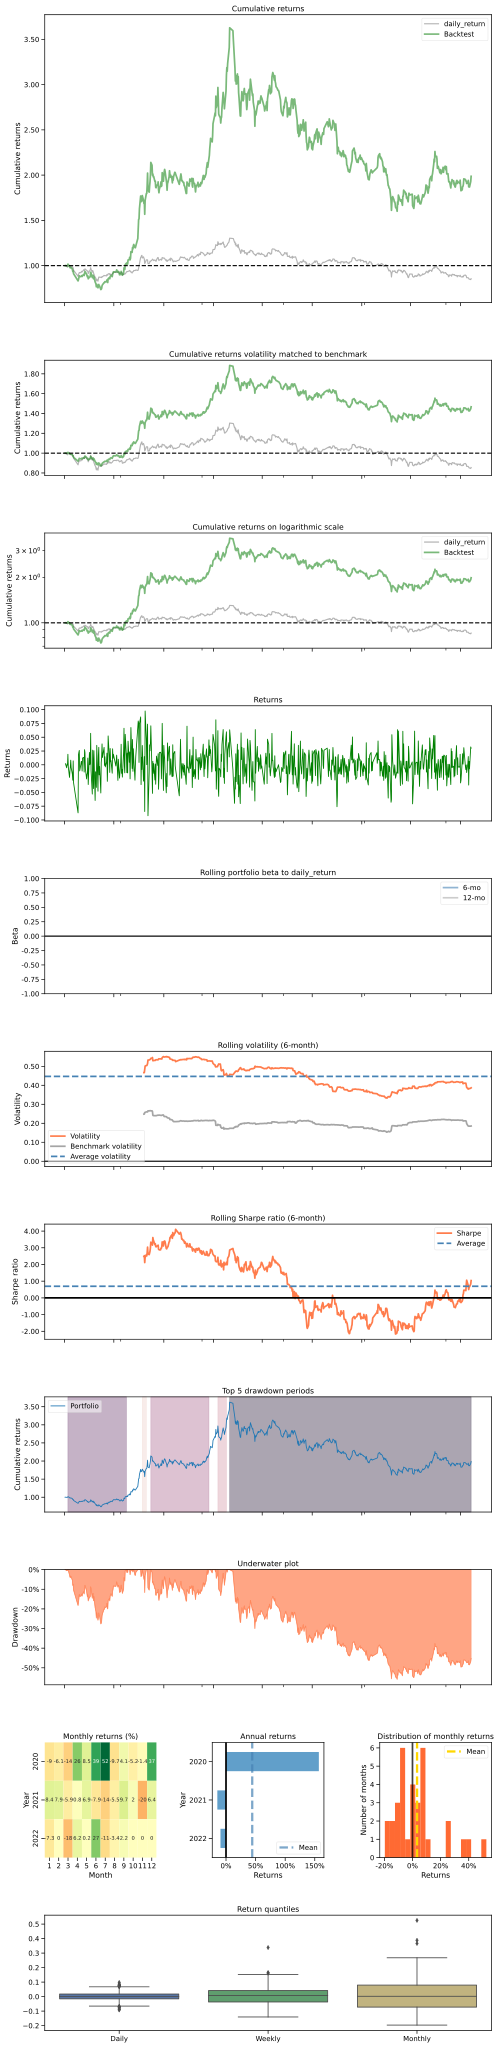

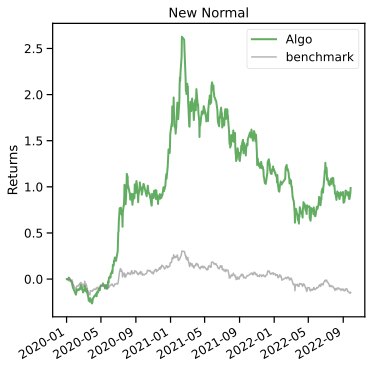

In [26]:
import pyfolio
from pyfolio import timeseries

%matplotlib inline

daily_return = get_daily_return(df_account_value)
daily_return_base = get_daily_return(baseline_df, value_col_name='close')

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = daily_return,
                                       benchmark_rets = daily_return_base, set_context=False)

In [27]:
plotter.plot_all()

AttributeError: 'DataFrame' object has no attribute 'dt'